## 0. Quickstart

In [62]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt

### 1. Working with data

**datasets**

In [63]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

**dataloader**

torch.Size([28, 28])


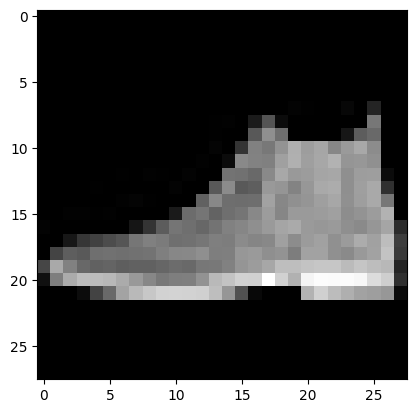

In [64]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

data_iter = iter(test_dataloader)
sample_data = next(data_iter)
sample_image = sample_data[0][0].squeeze()
print(sample_image.shape)
plt.imshow(sample_image, cmap='gray')
plt.show()

### 2. Create Models

**Set GPU**

In [65]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'using {device} device')

using mps device


In [66]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 3. Optimize the model parameters

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [68]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()
            current = (batch + 1) * len(X)
            print(f'loss: {loss:>7f} [{current:>5d} / {size:>5d}]')

In [69]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f'Test Error: \n Accuracy : {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}\n')

In [70]:
epochs = 5
for t in range(epochs):
    print(f'Epoch {t+1}')
    print('-------------------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.318944 [   64 / 60000]
loss: 0.678496 [ 6464 / 60000]
loss: 0.540616 [12864 / 60000]
loss: 0.546968 [19264 / 60000]
loss: 0.658696 [25664 / 60000]
loss: 0.488497 [32064 / 60000]
loss: 0.555179 [38464 / 60000]
loss: 0.526704 [44864 / 60000]
loss: 0.463182 [51264 / 60000]
loss: 0.654866 [57664 / 60000]
Test Error: 
 Accuracy : 82.5%, Avg loss: 0.489812

Epoch 2
-------------------------------
loss: 0.334316 [   64 / 60000]
loss: 0.404068 [ 6464 / 60000]
loss: 0.306666 [12864 / 60000]
loss: 0.446080 [19264 / 60000]
loss: 0.561221 [25664 / 60000]
loss: 0.390680 [32064 / 60000]
loss: 0.445509 [38464 / 60000]
loss: 0.577618 [44864 / 60000]
loss: 0.502317 [51264 / 60000]
loss: 0.511844 [57664 / 60000]
Test Error: 
 Accuracy : 80.9%, Avg loss: 0.533808

Epoch 3
-------------------------------
loss: 0.412899 [   64 / 60000]
loss: 0.306425 [ 6464 / 60000]
loss: 0.326428 [12864 / 60000]
loss: 0.429712 [19264 / 60000]
loss: 0.506807 [25664 / 60000]
l

### 4. Save models

In [71]:
torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch model state to model.pth')

Saved PyTorch model state to model.pth


### 5. Load models

In [72]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [73]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
